### This notebook is meant to be run in Colab. It clones data and code from the GitHub repo.

In [1]:
# Installs packages and clones GitHub repo to Colab
!pip install import-ipynb # to import functions from other ipynb files
!git clone https://github.com/peepkolberg/CNS-EOG-classifier.git
%cd CNS-EOG-classifier/

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=e2eda3eaa9a07becac7e13c8956ebb7073f886a651ef7bb7bf44093e7e3d62d8
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
Cloning into 'CNS-EOG-classifier'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 114 (delta 34), reused 55 (delta 19), pack-reused 43
Receiving objects: 100% (114/114), 23.29 MiB | 40.16 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/CNS-EOG-classifier


importing Jupyter notebook from preprocess.ipynb
     |████████████████████████████████| 1.1 MB 5.1 MB/s 




On average, 187k rows of data per experiment, 23k per class.


Average standard deviation of the gap between each measurement in each class of each experiment





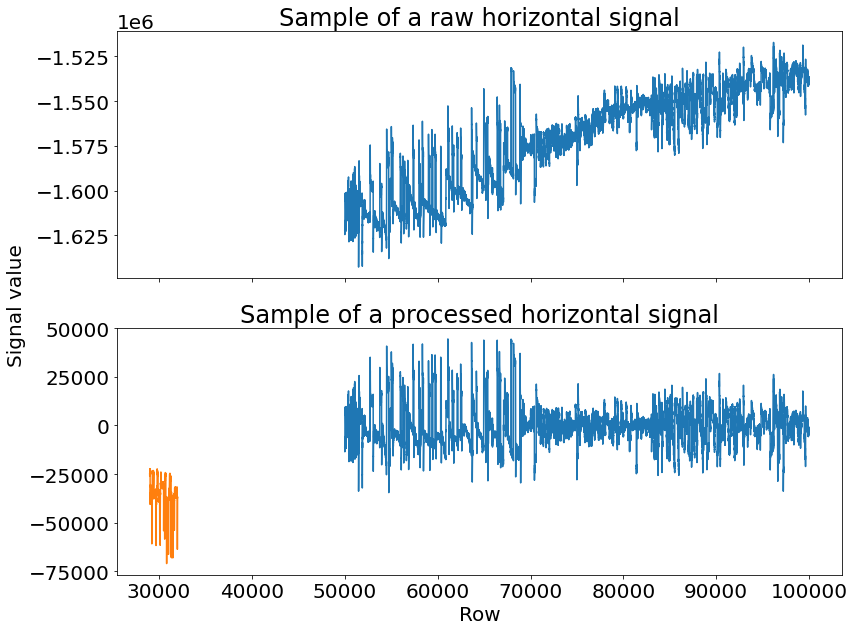

In [2]:
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import preprocess    #import the preprocess notebook
plt.rcParams.update({'font.size': 18})


In [3]:
# Various data preparing functions. 
import copy

def safely_remove_distraction_classes(datasets_dict):
    """
    Removes the distraction classes (labels 7 and 8) from the datasets without concatenating the surrounding class.
    Since each distraction is in the middle of another class, this function separates the surrounding class into two parts.
    The parts will be denoted by appending .1 or .2 to the surrounding class labels that are before and after the distraction class, respectively.
    """
    for participant, experiments in datasets_dict.items():
        for experiment, df in experiments.items():
            for dis_label in (7, 8):
                dis_df_idx = df[df['class'] == dis_label].index
    
                dis_start_idx = dis_df_idx[0]
                dis_end_idx = dis_df_idx[-1]
        
                surrounding_class_label = df['class'][dis_start_idx - 1]
            
                before_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index < dis_start_idx) ]
                after_dis_class = df[ (df['class'] == surrounding_class_label) & (df.index > dis_end_idx) ]
                
                df.loc[before_dis_class.index[0] : dis_start_idx, 'class'] = surrounding_class_label + 0.1
                df.loc[after_dis_class.index[0] : after_dis_class.index[-1]+1, 'class'] = surrounding_class_label + 0.2
                
                df.drop(index=range(dis_start_idx, dis_end_idx+1), inplace=True)
                #print(df['class'].unique())

def data_split(df, data_columns, chunk_size, window_step):
  """
  Outputs: NumPy arrays of data (X) and labels (y)

  Splits time-series data into equal-sized chunks.
  Also removes the .1 and .2 from previously separated labels.
  """

  X = []
  y = []

  for label in df['class'].unique():
    class_df = df[df['class'] == label]

    signals = np.asarray(class_df[data_columns])
    
    for i in range(0, len(signals), window_step): 
      chunk = signals[i : i + chunk_size]

      if len(chunk) != chunk_size:
        break

      X.append(chunk)
      y.append(int(label))

  return np.asarray(X), np.asarray(y) - 1    # Subtracting 1 from labels because keras tools expect numerical labels to start from 0

def split_datasets(datasets_dict, data_columns, chunk_size, sliding_window_step = -1):
  """ 
  Input: datasets_dict - 2D dictionary; hierarchy: dict[participant][experiment]
  Splits each dataset into chunks. If sliding_window_step argument is given, applies sliding window sampling.
  Also separates signal data (X) and labels (y).
  """

  # If step is not passed, move the window by the entire length of the window.
  if sliding_window_step == -1:
    sliding_window_step = chunk_size

  for participant, exps in datasets_dict.items():
    for experiment, data in exps.items():
      X, y = data_split(data, data_columns, chunk_size, sliding_window_step)
      datasets_dict[participant][experiment] = {'X': X, 'y': y} # <-- To also rename labels to their corresponding words, use rename_labels(y) instead of y

def one_hot_encode_labels(datasets_dict):
  for exps in datasets_dict.values():
    for data in exps.values():
      data['y'] = to_categorical(data['y'])

def print_data_dimensions(datasets_dict, cols):
  print('Rows in each experiment...')
  total_rows = 0
  total_labels = 0
  for participant, experiments in datasets_dict.items():
    for experiment, data in experiments.items():
      print(f"participant:{participant}   experiment:{experiment}")
      sig_shape = np.shape(data[cols])
      lab_shape = np.shape(data['class'])
      print(f"signals shape:{sig_shape}")
      print(f" labels shape:{lab_shape}")
      total_rows += sig_shape[0]
      total_labels += lab_shape[0]
  print(f"\nTotal {total_rows} rows of data and {total_labels} labels.")
  assert total_rows == total_labels

def concat_datasets(datasets_dict, participants, data_columns):
  X = []
  y = []

  for p in participants:
    for e in datasets_dict[p]:
      X.append(datasets_dict[p][e][data_columns])
      y.append(datasets_dict[p][e]['class'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y

def labels_to_words(numerical_labels):
    """ 
    For converting labels from numbers (0-7) to their word representations ('null', 'read', etc.)
    Input: numerical labels as a 1D array. 
    """
    replacements = {0: 'null', 
                    1: 'read', 
                    2: 'browse', 
                    3: 'write', 
                    4: 'video', 
                    5: 'copy', 
                    6: 'disspeak', 
                    7: 'disphone'}
    return np.asarray([replacements[old_label] for old_label in numerical_labels])

def plot_conf_matrix(true_labels, predictions):
  fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, predictions)).plot(cmap=plt.cm.Blues)
  plt.title(f"Participant {testing_participant} confusion matrix")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position('top')
  plt.show()

def standardize(standardized_dict, datasets_dict, participants, data_columns, scaler):
  for p in participants:
    standardized_dict[p] = {}
    
    for e, experiment_data in datasets_dict[p].items():
      standardized_dict[p][e] = pd.DataFrame(data = scaler.transform(experiment_data[data_columns]), columns = data_columns)
      standardized_dict[p][e]['class'] = copy.deepcopy(datasets_dict[p][e]['class'])

  return standardized_dict

def concat_chunks(datasets_dict, participants):
  X = []
  y = []

  for p in participants:
    for e in datasets_dict[p]:
      X.append(datasets_dict[p][e]['X'])
      y.append(datasets_dict[p][e]['y'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y



# UNUSED FUNCTIONS

def normalize_per_dataset(datasets_dict, data_columns):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      for col_name in data_columns:
        initial = np.asarray(data[col_name])
        max, min = np.max(initial), np.min(initial)
        normalized = 2 * ( (initial-min) / (max-min) ) - 1 # normalize between -1 and 1
        data[col_name] = normalized

def grid_search(X_train, y_train, X_test, y_test):
  model = KerasClassifier(build_fn=compile_model, verbose=0)

  batch_size = [10, 20, 30, 40, 60, 80, 100]
  epochs = [10, 20, 30, 50, 70, 100]
  optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  cnn_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dense_activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
  dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

  param_grid = dict(batch_size=batch_size,
                    epochs=epochs, 
                    optimizer=optimizer, 
                    cnn_activation=cnn_activation, 
                    dense_activation=dense_activation, 
                    dropout_rate=dropout_rate
                    )
  
  X = np.concatenate([X_train, X_test])
  y = np.concatenate([y_train, y_test])
  test_fold = np.concatenate([np.repeat(-1, len(y_train)), np.repeat(0, len(y_test))])
  
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=PredefinedSplit(test_fold=test_fold))
  grid_result = grid.fit(X, y)

  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [4]:
# Read files into dataframes (see function description in preprocess.ipynb for details)
datasets_dict = preprocess.read_all_files()

# Remove distraction classes
# The classes that surround the distraction class will be split into two parts by appending .1 or .2 to the label. 
safely_remove_distraction_classes(datasets_dict)

# Define which columns contain the desired signal data
data_columns = [
                #'signal_horizontal', 
                #'signal_vertical', 
                'signal_horizontal_nk', 
                'signal_vertical_nk'
                ]

# Normalization/standardization,
# splitting into chunks, and 
# one-hot-encoding labels is done in the training loop.

# Print the final dimensions of each dataset
print_data_dimensions(datasets_dict, data_columns)

Rows in each experiment...
participant:1   experiment:0
signals shape:(95555, 2)
 labels shape:(95555,)
participant:1   experiment:1
signals shape:(153837, 2)
 labels shape:(153837,)
participant:2   experiment:0
signals shape:(216969, 2)
 labels shape:(216969,)
participant:2   experiment:1
signals shape:(113083, 2)
 labels shape:(113083,)
participant:3   experiment:0
signals shape:(213370, 2)
 labels shape:(213370,)
participant:3   experiment:1
signals shape:(219878, 2)
 labels shape:(219878,)
participant:4   experiment:0
signals shape:(194701, 2)
 labels shape:(194701,)
participant:4   experiment:1
signals shape:(191298, 2)
 labels shape:(191298,)
participant:5   experiment:0
signals shape:(204106, 2)
 labels shape:(204106,)
participant:5   experiment:1
signals shape:(174829, 2)
 labels shape:(174829,)
participant:6   experiment:0
signals shape:(207580, 2)
 labels shape:(207580,)
participant:6   experiment:1
signals shape:(184430, 2)
 labels shape:(184430,)
participant:7   experiment:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2558, 8)           56        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1279, 8)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1275, 16)          656       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 637, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 631, 32)           3616      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 315, 32)          0

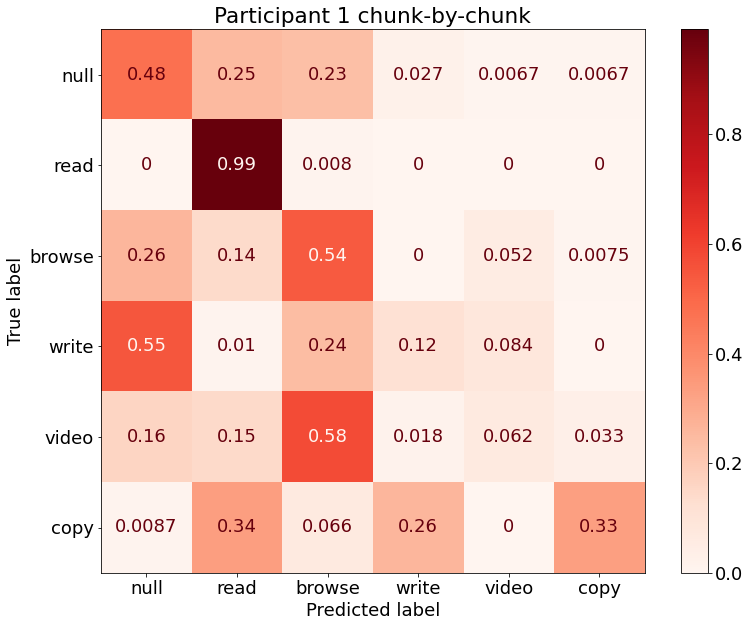


Started training for participant 2

Training data shape:   (13809, 2560, 2)   labels shape: (13809, 6)
Validation data shape: (3453, 2560, 2)     labels shape: (3453, 6)
Testing data shape:    (2216, 2560, 2)    labels shape: (2216, 6)

Epoch 1/25
216/216 [==============================] - 8s 35ms/step - loss: 5.0193 - accuracy: 0.3606 - val_loss: 1.8864 - val_accuracy: 0.4642
Epoch 2/25
216/216 [==============================] - 7s 33ms/step - loss: 1.7668 - accuracy: 0.4879 - val_loss: 1.6389 - val_accuracy: 0.5398
Epoch 3/25
216/216 [==============================] - 7s 33ms/step - loss: 1.5833 - accuracy: 0.5354 - val_loss: 1.6175 - val_accuracy: 0.5201
Epoch 4/25
216/216 [==============================] - 7s 33ms/step - loss: 1.4729 - accuracy: 0.5924 - val_loss: 1.4407 - val_accuracy: 0.6299
Epoch 5/25
216/216 [==============================] - 7s 33ms/step - loss: 1.3515 - accuracy: 0.6672 - val_loss: 1.3279 - val_accuracy: 0.6476
Epoch 6/25
216/216 [===========================

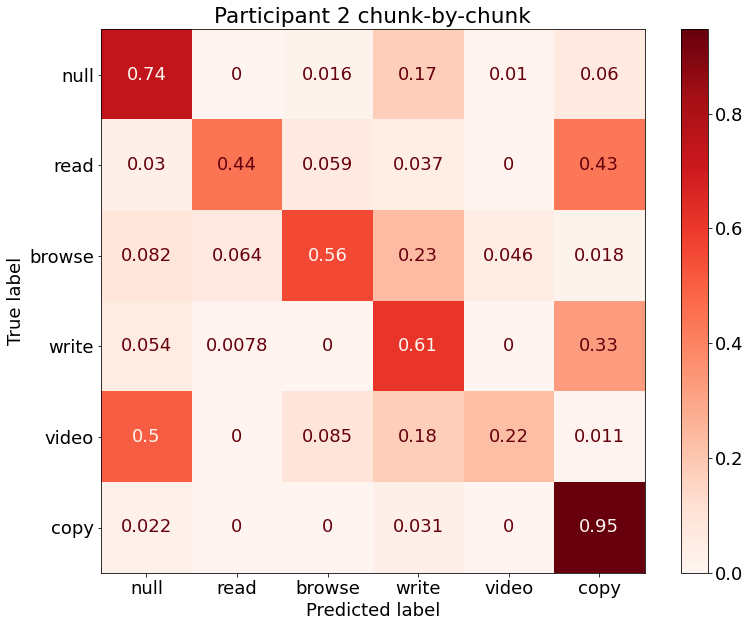


Started training for participant 3

Training data shape:   (13200, 2560, 2)   labels shape: (13200, 6)
Validation data shape: (3300, 2560, 2)     labels shape: (3300, 6)
Testing data shape:    (2978, 2560, 2)    labels shape: (2978, 6)

Epoch 1/25
207/207 [==============================] - 8s 35ms/step - loss: 5.4785 - accuracy: 0.3765 - val_loss: 2.0021 - val_accuracy: 0.4688
Epoch 2/25
207/207 [==============================] - 7s 34ms/step - loss: 1.8456 - accuracy: 0.5269 - val_loss: 1.7678 - val_accuracy: 0.5261
Epoch 3/25
207/207 [==============================] - 7s 33ms/step - loss: 1.6781 - accuracy: 0.6095 - val_loss: 1.6168 - val_accuracy: 0.6352
Epoch 4/25
207/207 [==============================] - 7s 33ms/step - loss: 1.5391 - accuracy: 0.6650 - val_loss: 1.6879 - val_accuracy: 0.5518
Epoch 5/25
207/207 [==============================] - 7s 33ms/step - loss: 1.4594 - accuracy: 0.6884 - val_loss: 1.3934 - val_accuracy: 0.6942
Epoch 6/25
207/207 [===========================

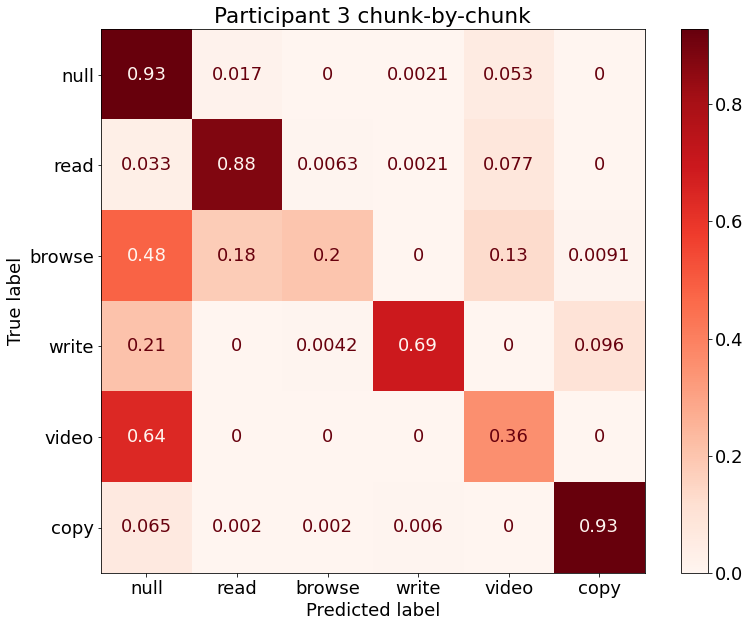


Started training for participant 4

Training data shape:   (13483, 2560, 2)   labels shape: (13483, 6)
Validation data shape: (3371, 2560, 2)     labels shape: (3371, 6)
Testing data shape:    (2624, 2560, 2)    labels shape: (2624, 6)

Epoch 1/25
211/211 [==============================] - 8s 35ms/step - loss: 4.7324 - accuracy: 0.3388 - val_loss: 1.8055 - val_accuracy: 0.4554
Epoch 2/25
211/211 [==============================] - 7s 34ms/step - loss: 1.7028 - accuracy: 0.4934 - val_loss: 1.5593 - val_accuracy: 0.5417
Epoch 3/25
211/211 [==============================] - 7s 34ms/step - loss: 1.5258 - accuracy: 0.5768 - val_loss: 1.4217 - val_accuracy: 0.6505
Epoch 4/25
211/211 [==============================] - 7s 33ms/step - loss: 1.4052 - accuracy: 0.6533 - val_loss: 1.2948 - val_accuracy: 0.6787
Epoch 5/25
211/211 [==============================] - 7s 33ms/step - loss: 1.2857 - accuracy: 0.6919 - val_loss: 1.2176 - val_accuracy: 0.7401
Epoch 6/25
211/211 [===========================

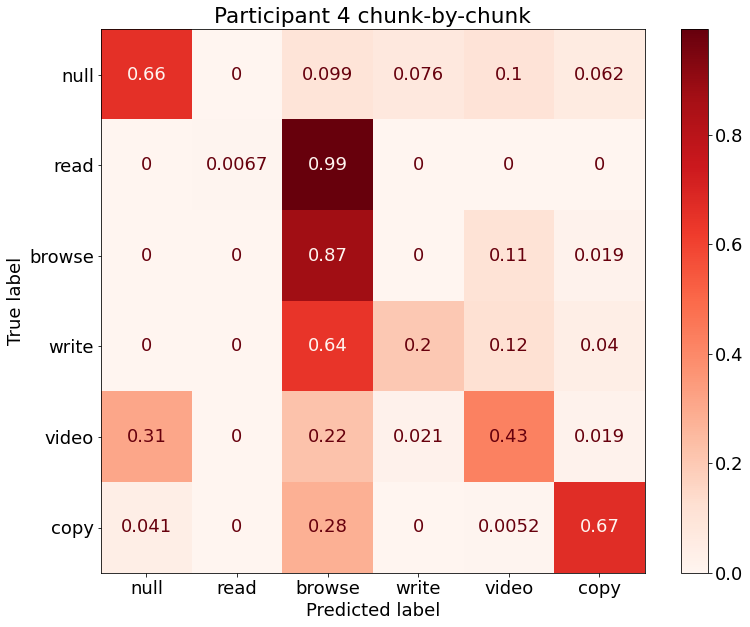


Started training for participant 5

Training data shape:   (13548, 2560, 2)   labels shape: (13548, 6)
Validation data shape: (3387, 2560, 2)     labels shape: (3387, 6)
Testing data shape:    (2543, 2560, 2)    labels shape: (2543, 6)

Epoch 1/25
212/212 [==============================] - 9s 35ms/step - loss: 4.5874 - accuracy: 0.3681 - val_loss: 1.8016 - val_accuracy: 0.4759
Epoch 2/25
212/212 [==============================] - 7s 34ms/step - loss: 1.7009 - accuracy: 0.4883 - val_loss: 1.6239 - val_accuracy: 0.5155
Epoch 3/25
212/212 [==============================] - 7s 33ms/step - loss: 1.5825 - accuracy: 0.5796 - val_loss: 1.4520 - val_accuracy: 0.6525
Epoch 4/25
212/212 [==============================] - 7s 34ms/step - loss: 1.4090 - accuracy: 0.6587 - val_loss: 1.2617 - val_accuracy: 0.7222
Epoch 5/25
212/212 [==============================] - 7s 33ms/step - loss: 1.2858 - accuracy: 0.6961 - val_loss: 1.1784 - val_accuracy: 0.7484
Epoch 6/25
212/212 [===========================

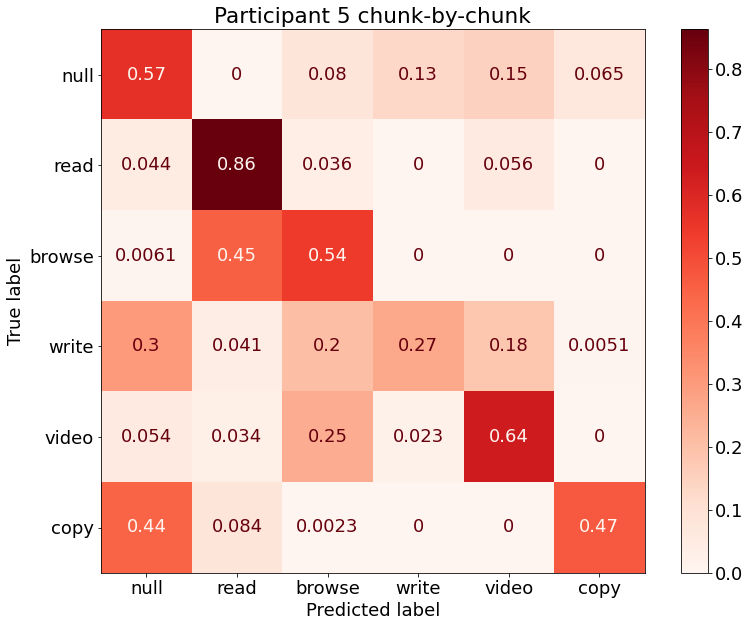


Started training for participant 6

Training data shape:   (13442, 2560, 2)   labels shape: (13442, 6)
Validation data shape: (3361, 2560, 2)     labels shape: (3361, 6)
Testing data shape:    (2675, 2560, 2)    labels shape: (2675, 6)

Epoch 1/25
211/211 [==============================] - 8s 35ms/step - loss: 4.2385 - accuracy: 0.3758 - val_loss: 1.7958 - val_accuracy: 0.4945
Epoch 2/25
211/211 [==============================] - 7s 34ms/step - loss: 1.7572 - accuracy: 0.5225 - val_loss: 1.9512 - val_accuracy: 0.4775
Epoch 3/25
211/211 [==============================] - 7s 34ms/step - loss: 1.5904 - accuracy: 0.6331 - val_loss: 1.6598 - val_accuracy: 0.6317
Epoch 4/25
211/211 [==============================] - 7s 34ms/step - loss: 1.4576 - accuracy: 0.6795 - val_loss: 1.8209 - val_accuracy: 0.5222
Epoch 5/25
211/211 [==============================] - 7s 33ms/step - loss: 1.5082 - accuracy: 0.6553 - val_loss: 1.3788 - val_accuracy: 0.6748
Epoch 6/25
211/211 [===========================

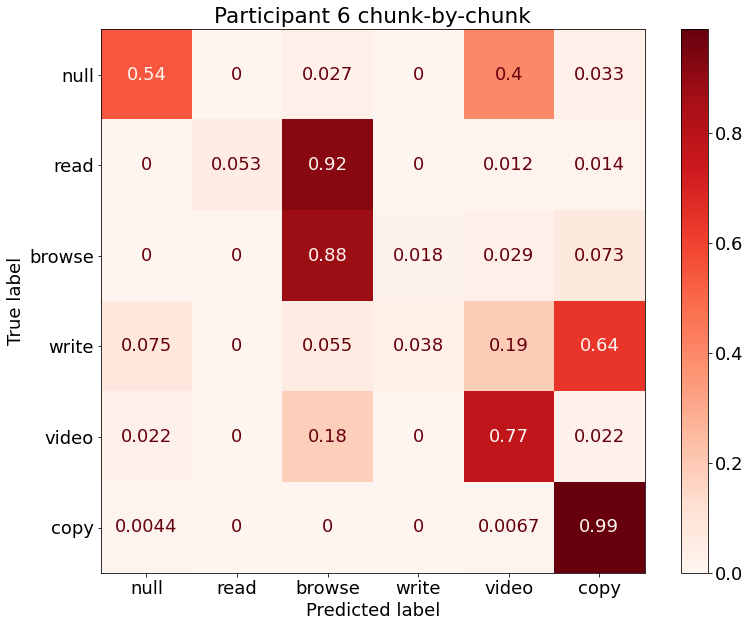


Started training for participant 7

Training data shape:   (13735, 2560, 2)   labels shape: (13735, 6)
Validation data shape: (3434, 2560, 2)     labels shape: (3434, 6)
Testing data shape:    (2309, 2560, 2)    labels shape: (2309, 6)

Epoch 1/25
215/215 [==============================] - 8s 35ms/step - loss: 4.2698 - accuracy: 0.3653 - val_loss: 1.8308 - val_accuracy: 0.4971
Epoch 2/25
215/215 [==============================] - 7s 34ms/step - loss: 1.6860 - accuracy: 0.5364 - val_loss: 1.5026 - val_accuracy: 0.6159
Epoch 3/25
215/215 [==============================] - 7s 34ms/step - loss: 1.5084 - accuracy: 0.6228 - val_loss: 1.4388 - val_accuracy: 0.6535
Epoch 4/25
215/215 [==============================] - 7s 34ms/step - loss: 1.3887 - accuracy: 0.6649 - val_loss: 1.2945 - val_accuracy: 0.7111
Epoch 5/25
215/215 [==============================] - 7s 34ms/step - loss: 1.3080 - accuracy: 0.6904 - val_loss: 1.4713 - val_accuracy: 0.6080
Epoch 6/25
215/215 [===========================

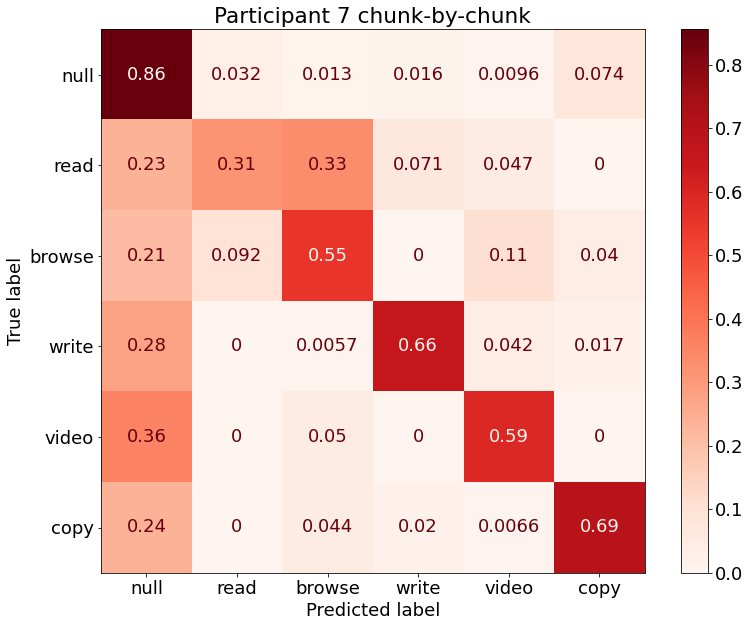


Started training for participant 8

Training data shape:   (13544, 2560, 2)   labels shape: (13544, 6)
Validation data shape: (3387, 2560, 2)     labels shape: (3387, 6)
Testing data shape:    (2547, 2560, 2)    labels shape: (2547, 6)

Epoch 1/25
212/212 [==============================] - 8s 35ms/step - loss: 4.6709 - accuracy: 0.3517 - val_loss: 1.8741 - val_accuracy: 0.4508
Epoch 2/25
212/212 [==============================] - 7s 34ms/step - loss: 1.7618 - accuracy: 0.4945 - val_loss: 1.7154 - val_accuracy: 0.5161
Epoch 3/25
212/212 [==============================] - 7s 34ms/step - loss: 1.5863 - accuracy: 0.5668 - val_loss: 1.4719 - val_accuracy: 0.6448
Epoch 4/25
212/212 [==============================] - 7s 34ms/step - loss: 1.4691 - accuracy: 0.6284 - val_loss: 1.4416 - val_accuracy: 0.6274
Epoch 5/25
212/212 [==============================] - 7s 34ms/step - loss: 1.3784 - accuracy: 0.6749 - val_loss: 1.2987 - val_accuracy: 0.7030
Epoch 6/25
212/212 [===========================

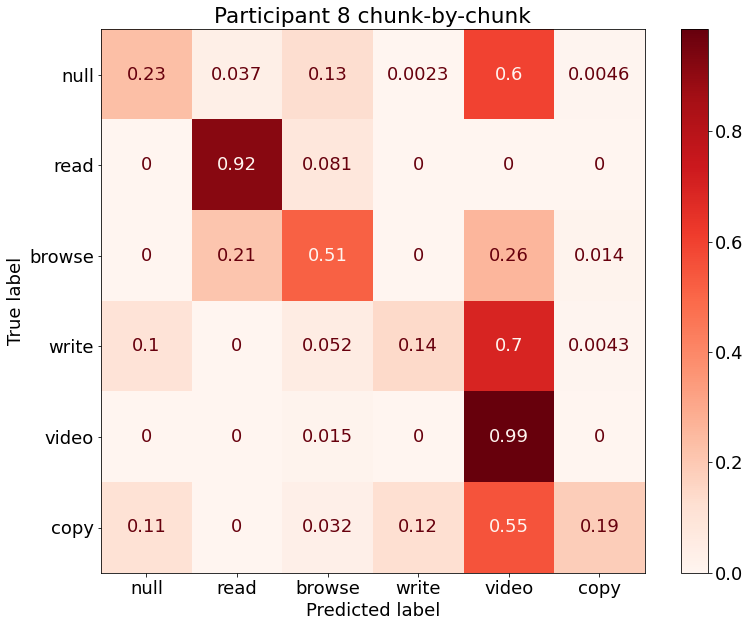

precisions and recalls per class - summed over participants

null: precision(0.48)   recall(0.63)
read: precision(0.71)   recall(0.55)
browse: precision(0.43)   recall(0.57)
write: precision(0.63)   recall(0.35)
video: precision(0.5)   recall(0.55)
copy: precision(0.72)   recall(0.65)
mean: precision(0.58)   recall(0.55)


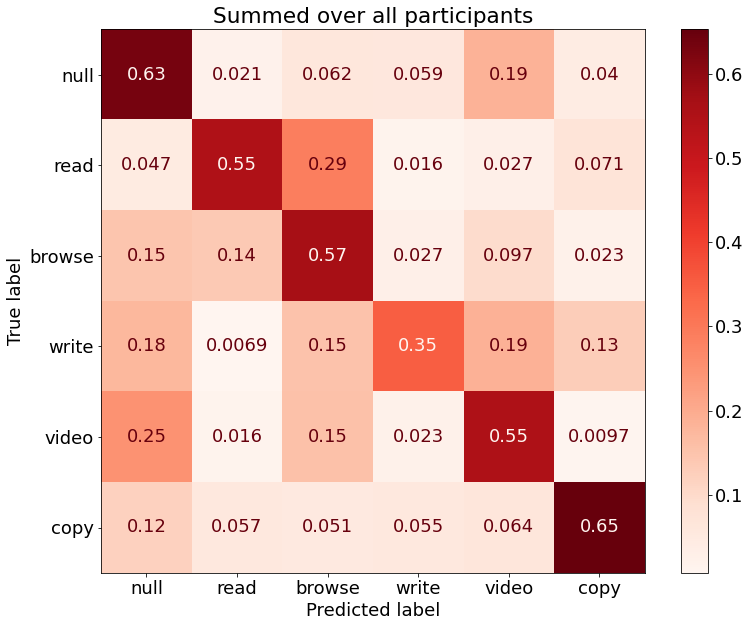

precisions and recalls for each class per participant

participant 1
null: precision(0.24)   recall(0.48)
read: precision(0.48)   recall(0.99)
browse: precision(0.35)   recall(0.54)
write: precision(0.15)   recall(0.12)
video: precision(0.35)   recall(0.06)
copy: precision(0.93)   recall(0.33)
mean: precision(0.42)   recall(0.42)

participant 2
null: precision(0.64)   recall(0.74)
read: precision(0.91)   recall(0.44)
browse: precision(0.74)   recall(0.56)
write: precision(0.4)   recall(0.61)
video: precision(0.76)   recall(0.22)
copy: precision(0.46)   recall(0.95)
mean: precision(0.65)   recall(0.59)

participant 3
null: precision(0.38)   recall(0.93)
read: precision(0.8)   recall(0.88)
browse: precision(0.95)   recall(0.2)
write: precision(0.99)   recall(0.69)
video: precision(0.57)   recall(0.36)
copy: precision(0.9)   recall(0.93)
mean: precision(0.76)   recall(0.66)

participant 4
null: precision(0.67)   recall(0.66)
read: precision(1.0)   recall(0.01)
browse: precision(0.3)   rec

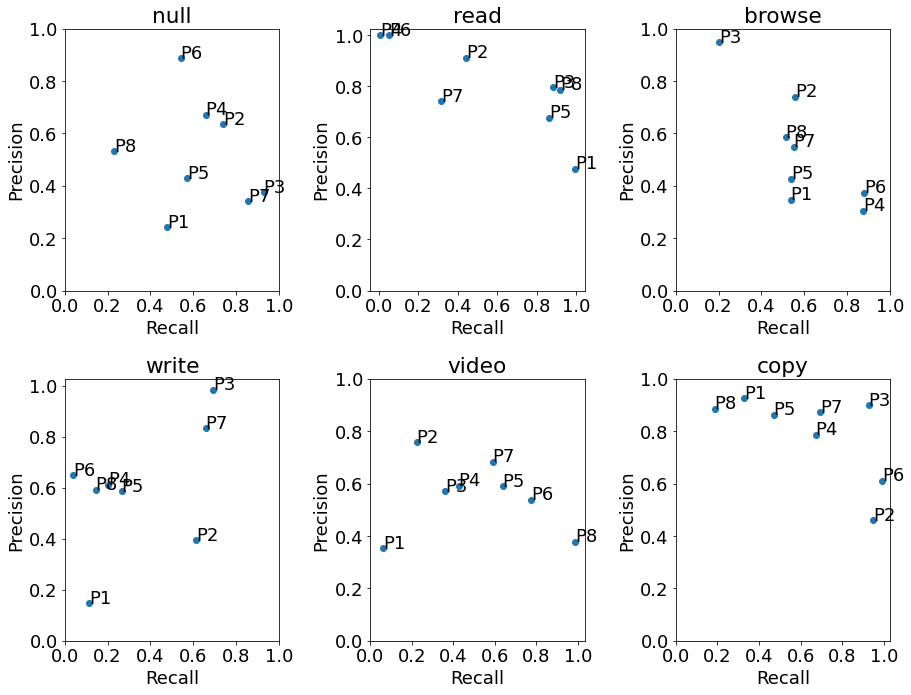

In [5]:
# TESTING REGULAR CNN

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier


def compile_model(input_shape = (625, 4), output_nodes = 6, cnn_activation = 'relu', dense_activation = 'relu', dropout_rate = 0.2):
  model = Sequential()

  model.add(Input(shape = input_shape))

  model.add(Conv1D(8, 3, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(16, 5, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(32, 7, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Conv1D(64, 9, strides=1, activation=cnn_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(MaxPooling1D(2))

  model.add(Flatten())

  # Use half as many nodes as output of the flatten layer
  model.add(Dense(4896, activation=dense_activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(Dropout(dropout_rate))
  
  model.add(Dense(output_nodes, activation='softmax'))

  opt = Adam(learning_rate = 0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

def collect(trues, preds):
  # 2D dictionary
  # hierarchy: true label -> 'total'         -> how many times that label appears in the test set
  #                       -> predicted label -> how many times the model predicted that label
  predictions = {}
  for c in np.unique(trues):
    predictions[c] = defaultdict(lambda: 0)

  # Count all predictions
  for true_label, pred_label in zip(trues, preds):
    #predictions[true_label]['total'] += 1
    predictions[true_label][pred_label] += 1

  # Summarize all predictions
  true_labels_summed = []
  predictions_summed = []

  for true, d in predictions.items():
    true_labels_summed.append(true)
    predictions_summed.append(max(d, key=d.get))

  return true_labels_summed, predictions_summed

def plot_conf_matrix_per_participant(participant, trues, preds):
  cm_norm = confusion_matrix(trues, preds, normalize = 'true')
  fig = ConfusionMatrixDisplay(confusion_matrix=cm_norm).plot(cmap=plt.cm.Reds)
  plt.title(f"Participant {participant} chunk-by-chunk")
  ax = plt.gca()
  plt.xticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.yticks([0,1,2,3,4,5], ['null','read','browse','write','video','copy'])
  plt.show()  

def plot_summed_conf_matrix(trues, preds):
  cm_norm = confusion_matrix(trues, preds, normalize = 'true')
  fig = ConfusionMatrixDisplay(confusion_matrix=cm_norm).plot(cmap=plt.cm.Reds)
  plt.title(f"Summed over all participants")
  ax = plt.gca()
  titles = ['null','read','browse','write','video','copy']
  plt.xticks([0,1,2,3,4,5], titles)
  plt.yticks([0,1,2,3,4,5], titles)
  plt.savefig(f"summed.png")

  cm_counts = confusion_matrix(trues, preds)
  precisions = np.diag(cm_counts) / np.sum(cm_counts, axis = 0)
  recalls = np.diag(cm_counts) / np.sum(cm_counts, axis = 1)

  print('precisions and recalls per class - summed over participants\n')
  for i, (p, r) in enumerate(zip(precisions, recalls)):
    print(f'{titles[i]}: precision({round(p, 2)})   recall({round(r, 2)})')

  print(f'mean: precision({round(np.mean(precisions), 2)})   recall({round(np.mean(recalls), 2)})')
  plt.show()


def plot_individual_precisions_recalls(participant_predictions):
  f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

  annotations = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
  titles = ['null','read','browse','write','video','copy']
  axes = [ax1, ax2, ax3, ax4, ax5, ax6]

  precisions = []
  recalls = []
  print(f'precisions and recalls for each class per participant')

  for p, labels in participant_predictions.items():
    cm = confusion_matrix(labels['true'], labels['predictions'])
    precision1 = np.diag(cm) / np.sum(cm, axis = 0)
    recall1 = np.diag(cm) / np.sum(cm, axis = 1)
    precisions.append(precision1)
    recalls.append(recall1)

    print(f'\nparticipant {p}')
    for c, (p, r) in enumerate(zip(precision1, recall1)):
      print(f'{titles[c]}: precision({round(p, 2)})   recall({round(r, 2)})')

    print(f'mean: precision({round(np.mean(precision1), 2)})   recall({round(np.mean(recall1), 2)})')

  precisions = np.transpose(precisions)
  recalls = np.transpose(recalls)

  for i, ax in enumerate(axes):
    ax.scatter(recalls[i], precisions[i])
    ax.set_title(titles[i])
    ax.set(xlabel='Recall', ylabel='Precision')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    for j, text in enumerate(annotations):
      ax.annotate(text, (recalls[i][j], precisions[i][j]))

  f.tight_layout()

  plt.savefig(f"individuals.png")
  plt.show()


# For each test, one participant is the test participant (not included in the training set).
first_iteration = True
chunk_by_chunk_true_labels = []
chunk_by_chunk_predictions = []
summed_true_labels = []
summed_predictions = []
participant_predictions = {}

for testing_participant in range(1, 9):
  training_participants = list(range(1, 9))
  training_participants.remove(testing_participant)

  # Get concatenated tables for fitting StandardScalers.
  X_train, y_train = concat_datasets(datasets_dict, training_participants, data_columns) # The returned y_train and y_test lists aren't actually used.
  X_test, y_test = concat_datasets(datasets_dict, [testing_participant], data_columns)
  X_train = pd.DataFrame(data = X_train, columns = data_columns)
  X_test = pd.DataFrame(data = X_test, columns = data_columns)

  # Fit the scalers on both whole datasets.
  train_scaler = StandardScaler(copy = True).fit(X_train) # These scalers do NOT change the values in-place, but return a copy.
  test_scaler = StandardScaler(copy = True).fit(X_test)

  # Standardize the training and test sets.
  standardized_dict = standardize({}, datasets_dict, training_participants, data_columns, train_scaler) 
  standardized_dict = standardize(standardized_dict, datasets_dict, [testing_participant], data_columns, test_scaler)

  # Split each class in dataset into chunks. Can be used for sliding window sampling (sliding_window_step argument must be given).
  # Also subtracts 1 from all labels so they start from 0.
  chunk_size = 128 * 20
  sliding_window_step = 128 * 1
  split_datasets(standardized_dict, data_columns, chunk_size, sliding_window_step)

  # One-hot encode labels
  one_hot_encode_labels(standardized_dict)

  # Concatenate chunks
  X_train, y_train = concat_chunks(standardized_dict, training_participants)
  X_test, y_test = concat_chunks(standardized_dict, [testing_participant])

  # Further divide the training set into training and validation sets
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2) # this also shuffles train and val sets

  # Makes a fresh model for every person
  model = compile_model(input_shape = X_train.shape[1:], output_nodes = y_train.shape[1])

  if first_iteration: # print the model summary only on the first iteration
    model.summary()
    first_iteration = False
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  print(f"\nStarted training for participant {testing_participant}\n")
  print(f"Training data shape:   {X_train.shape}   labels shape: {y_train.shape}")
  print(f"Validation data shape: {X_val.shape}     labels shape: {y_val.shape}")
  print(f"Testing data shape:    {X_test.shape}    labels shape: {y_test.shape}\n")

  model.fit(X_train, y_train, batch_size=64, epochs=25, validation_data=(X_val, y_val), verbose=1)

  # Get the model's predictions for each chunk
  print(f"\nTesting participant {testing_participant}\n")
  true_labels = [np.argmax(el) for el in y_test]
  predictions = [np.argmax(el) for el in model.predict(X_test)]

  participant_predictions[testing_participant] = {'true': true_labels, 
                                                  'predictions': predictions}

  plot_conf_matrix_per_participant(testing_participant, true_labels, predictions)

  chunk_by_chunk_true_labels.append(true_labels)
  chunk_by_chunk_predictions.append(predictions)

chunk_by_chunk_true_labels = np.concatenate(chunk_by_chunk_true_labels)
chunk_by_chunk_predictions = np.concatenate(chunk_by_chunk_predictions)

plot_summed_conf_matrix(chunk_by_chunk_true_labels, chunk_by_chunk_predictions)
plot_individual_precisions_recalls(participant_predictions)